In [1]:
import numpy as np
import casadi as ca
import gym
import gym_custom_envs
import time as tt
import random
from gym import wrappers
from IPython.display import clear_output

In [2]:
class Model():
    def __init__(self):
        "Model Parameters"
        self.env = gym.make("Quadrotor2D-v0", dt=0.02)
        self.m = self.env.m
        self.I = self.env.I
        self.gravity = self.env.gravity
        self.l = self.env.l
        self.r = self.l/2
        self.x_max = self.env.x_threshold
        self.y_max = self.env.y_threshold
        self.theta_max = np.pi
        self.goal = self.env.goal
#         if self.theta_max == 2*np.pi:
#             self.theta_min = 0.
#         elif self.theta_max == np.pi:
        self.theta_min = -np.pi
        
        "Model Hyper-Parameters"
        self.T = 1.
        self.u_max = abs(10*self.m*self.gravity)
        self.N = (self.T/self.env.dt).__int__()
        
    def modelDynamics(self, state, u):
        "Return the state_dot"
        x_ddot = -((u[0, 0] + u[1, 0])*ca.sin(state[2, 0]))/self.m
        y_ddot = (((u[0, 0] + u[1, 0])*ca.cos(state[2, 0])) - (self.m*self.gravity))/self.m
        theta_ddot = ((u[0, 0] - u[1, 0])*self.l/2)/self.I
        
        return x_ddot, y_ddot, theta_ddot

In [3]:
class Nlp(Model):
    def __init__(self, Model, start):
        "Initialise Optimization Variables"
        self.opti = ca.Opti()
        self.state = []
        self.u = []
        self.start = start
        self.goal = np.array([Model.goal[0], Model.goal[1], Model.goal[2], 0., 0., 0.])
        self.goal = self.goal.reshape(6, 1)
        
        for i in range(Model.N):
            self.state.append([self.opti.variable(3, 1), self.opti.variable(3, 1)])
            self.u.append(self.opti.variable(2, 1))
            
        self.ddq = []
        for i in range(Model.N):
            x_ddot, y_ddot, theta_ddot = Model.modelDynamics(self.state[i][0], self.u[i])
            self.ddq.append([x_ddot, y_ddot, theta_ddot])
        
        "Cost function"
        self.cost = self.getCost(self.state, self.u, Model.N, Model.T)
        self.opti.minimize(self.cost)
        
        "Constraints"
        self.constraints = self.getConstraints(Model, self.state, self.ddq, self.u)
        self.opti.subject_to(self.constraints)
        
        "Bounds"
        self.bounds = self.getBounds(Model, self.state, self.u)
        self.opti.subject_to(self.bounds)
        p_opts = {"expand":True}
        s_opts = {"max_iter": 1000}
        self.opti.solver("ipopt",p_opts,s_opts)
        
        "Initial Condition"
        iniq = np.zeros((3,Model.N))
        inidq = np.zeros((3,Model.N))
        iniu = np.zeros((2,Model.N))
        for j in range(3):
            for i in range(Model.N):
                self.opti.set_initial(self.state[i][0][j],
                            (self.start[j, 0] + (i/(Model.N - 1))*(self.goal[j, 0] - self.start[j, 0])))
                iniq[j, i] = (self.start[j, 0] + (i/(Model.N - 1))*(self.goal[j, 0] - self.start[j, 0]))
                
                self.opti.set_initial(self.state[i][1][j],
                            (self.goal[j+3, 0] - self.start[j+3, 0])/(Model.N-1))
                inidq[j, i] = (self.goal[j+3, 0] - self.start[j+3, 0])/(Model.N-1)                
                
                if j < 2:
                    self.opti.set_initial(self.u[i][j, 0],
                            ((i/(Model.N - 1))*(Model.m*Model.gravity/2)))
                
        self.initial = [iniq,inidq,iniu]
        
    def getCost(self, state, u, N, T):
        J = 0
        print(N)
        h = T/N
        for i in range(N-1):
            J += h*ca.sum1(u[i]**2 + u[i+1]**2)/2
            J += h*ca.sum1(state[i][0]**2 + state[i][1]**2 + state[i+1][0]**2 + state[i+1][1]**2)/2
        return J 
    
    def getConstraints(self, Model, state, ddq, u):
        ceq = []
        h = Model.T/Model.N
        
        "Collocation Constraints"
        for i in range(Model.N - 1):
            ceq.append((((state[i][0] + state[i+1][0])*h/2) - (state[i+1][1] - state[i][1]) == 0))
            for j in range(3):
                ceq.append((((state[i][1][j, 0] + state[i+1][1][j, 0])*h/2) - (ddq[i+1][j] - ddq[i][j]) == 0))
            
        "Boundary Constraints"
        ceq.append((state[0][0][0, 0] - self.start[0, 0] == 0))
        ceq.append((state[0][0][1, 0] - self.start[1, 0] == 0))
        ceq.append((state[0][0][2, 0] - self.start[2, 0] == 0))
        ceq.append((state[0][1][0, 0] - self.start[3, 0] == 0))
        ceq.append((state[0][1][1, 0] - self.start[4, 0] == 0))
        ceq.append((state[0][1][2, 0] - self.start[5, 0] == 0))
        ceq.append((state[-1][0][0, 0] - self.goal[0, 0] == 0))
        ceq.append((state[-1][0][1, 0] - self.goal[1, 0] == 0))
        ceq.append((state[-1][0][2, 0] - self.goal[2, 0] == 0))
        ceq.append((state[-1][1][0, 0] - self.goal[3, 0] == 0))
        ceq.append((state[-1][1][1, 0] - self.goal[4, 0] == 0))
        ceq.append((state[-1][1][2, 0] - self.goal[5, 0] == 0))
#         ceq.append((u[-1][0, 0] - (Model.m*Model.gravity/2) == 0))
#         ceq.append((u[-1][1, 0] - (Model.m*Model.gravity/2) == 0))
        return ceq
    
    def getBounds(self, Model, state, u):
        c = []
        f = 200
        for i in range(Model.N):
            q  = state[i][0]
            dq = state[i][1]
            tu  = u[i]
            c.extend([
                      self.opti.bounded(-2*Model.x_max,q[0],2*Model.x_max),
                      self.opti.bounded(-2*Model.y_max,q[1],2*Model.y_max),
                      self.opti.bounded(-np.pi,q[2],np.pi),
                      self.opti.bounded(-f,dq[0],f),
                      self.opti.bounded(-f,dq[1],f),
                      self.opti.bounded(-f*np.pi,dq[2],f*np.pi),
                      self.opti.bounded(-Model.u_max,tu[0, 0],Model.u_max),
                      self.opti.bounded(-Model.u_max,tu[1, 0],Model.u_max)
                     ])
        return c

In [4]:
quad = Model()
s = quad.env.reset().reshape(6, 1)
problem = Nlp(quad, s)
solution = problem.opti.solve()

50

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:     1678
Number of nonzeros in inequality constraint Jacobian.:      400
Number of nonzeros in Lagrangian Hessian.............:      500

Total number of variables............................:      400
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of e

  88  2.4486003e-01 1.36e-05 1.19e+02  -1.0 1.64e-01  -1.2 1.00e+00 1.00e+00h  1
  89  2.4461572e-01 1.48e-05 8.95e+01  -1.0 1.95e-01  -0.8 1.00e+00 2.50e-01h  3
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90  2.4352503e-01 1.12e-05 4.15e+02  -1.0 7.37e-02  -0.4 1.00e+00 1.00e+00h  1
  91  2.4268608e-01 6.92e-06 1.13e+03  -1.0 6.14e-02   0.1 1.00e+00 1.00e+00h  1
  92  2.4149549e-01 1.95e-06 3.87e+02  -1.0 4.74e-02   0.5 1.00e+00 1.00e+00h  1
  93  2.4152671e-01 8.33e-08 2.07e+02  -1.0 5.82e-03   0.9 1.00e+00 1.00e+00h  1
  94  2.4136182e-01 7.05e-09 1.32e+01  -1.0 3.40e-03   0.4 1.00e+00 1.00e+00h  1
  95  2.4087562e-01 8.46e-08 1.42e+00  -1.0 8.91e-03  -0.0 1.00e+00 1.00e+00f  1
  96  2.3953634e-01 7.99e-07 1.33e+00  -1.0 2.46e-02  -0.5 1.00e+00 1.00e+00f  1
  97  2.3631797e-01 8.60e-06 2.09e+01  -1.0 6.74e-02  -1.0 1.00e+00 1.00e+00f  1
  98  2.3527256e-01 1.28e-06 7.10e+00  -1.0 1.98e-02  -0.6 1.00e+00 1.00e+00h  1
  99  2.3496048e-01 1.47e-07

[[-1.8702449 ]
 [-1.70869522]
 [-0.3984013 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]


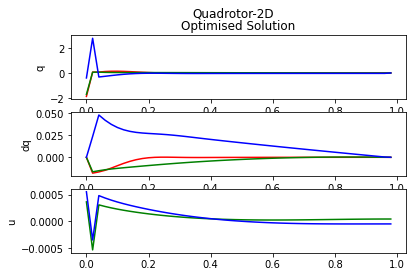

In [5]:
%matplotlib inline
from matplotlib import pyplot as plt
q = []; dq = []; u = []; pos = []; time = []
print(s)
for j in range(3):
    tempq = [];tempdq = [];tempu = [];temp = []
    
    for i in range(quad.N):
        tempq.append(solution.value(problem.state[i][0][j]))    
        tempdq.append(solution.value(problem.state[i][1][j]))
        if j < 2:
            tempu.append(solution.value(problem.u[i][j]))
            
    q.append(tempq)
    dq.append(tempdq)
    pos.append(temp)   
    u.append(tempu)

time = np.arange(0.0, quad.T, quad.T/quad.N)

name = ['q','dq','u']

plt.subplot(311)
plt.title('Optimised Solution')
plt.plot(time, q[:][0],'r', time, q[:][1],'g',time ,q[:][2],'b')
plt.ylabel(name[0])

plt.subplot(312)
plt.plot(time, dq[:][0],'r',time, dq[:][1],'g',time, dq[:][2],'b')
plt.ylabel(name[1])

plt.subplot(313)
plt.plot(time, u[:][0],'g',time, u[:][1],'b')
plt.ylabel(name[2])

plt.suptitle('Quadrotor-2D')
plt.show()

In [6]:
done = False
jj = 0
print(len(u[0][:]))
while not done:    
#     a = [u_opt[jj].__float__(),u_opt[jj+1].__float__()]
#         print('Theta = ', round(np.rad2deg(s[0, 2]), 3))
#         print('u = ', a.T)
#         print("Reaction = ", round((a[0] + a[1])[0, 0] - m*g, 3))
#         print("Cost = ", round(np.dot(s, np.dot(S, s.T))[0, 0], 3))
    a = [u[0][jj], u[1][jj]]
    ns, r, done, _ = quad.env.step([a[0], a[1]])
    s = ns.reshape(1, 6)
    jj += 1
    quad.env.render()
    print(a, done)
    clear_output(wait=True)
    tt.sleep(1)
quad.env.close()

[6.0874497455032225e-05, 7.769347713550682e-05] True
